# Bu araba kaç lakh ? 
## İçindekiler
### 1.Giriş
### 2.Veri Analizi
### 3.Model Oluşturma ve Seçme
### 4.Model Sonuçlarını Yorumlama
### 5.Tahmin Yapma
### 6.Varsayımların Sağlanması Kontrolü    
### 7.Sonuç

### 1.Giriş  
Bu projemizde Hindistan'da kullanılmış otomobil piyasasına dair bilgiler içeren bir veri kümesi ile çalışacağız.Nihai amacımız oluşturacağımız model ile arabanın fiyatını tahmin edebilmek. Veri setimizde hedef değişken olarak seçtiğimiz **Price** birim olarak Hindiatan'ın yerel para birimi olan Lakh cinsinden.

Verimizi tanımaya geçmeden ihtiyacımız olacak kütüphaneleri yüklüyoruz ve veri dosyamızı okuyoruz.

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.api as sm
import warnings
import seaborn as sns

from sklearn import linear_model
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, ElasticNet, Lasso, LassoLarsCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from statsmodels.tsa.stattools import acf
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import jarque_bera, normaltest, bartlett, levene


warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [2]:
df=pd.read_csv('used_car_train.csv')

### 2.Veri Analizi

In [3]:
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.000,NaN,1.750
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.000,NaN,12.500
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.000,8.61 Lakh,4.500
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.000,NaN,6.000
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.000,NaN,17.740


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
Unnamed: 0           6019 non-null int64
Name                 6019 non-null object
Location             6019 non-null object
Year                 6019 non-null int64
Kilometers_Driven    6019 non-null int64
Fuel_Type            6019 non-null object
Transmission         6019 non-null object
Owner_Type           6019 non-null object
Mileage              6017 non-null object
Engine               5983 non-null object
Power                5983 non-null object
Seats                5977 non-null float64
New_Price            824 non-null object
Price                6019 non-null float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.4+ KB


In [5]:
#veri kümesinde tekrarlayan satır varsa siliyoruz.
print(df.shape)
df = df.drop_duplicates(keep='first')
print(df.shape)

(6019, 14)
(6019, 14)


In [6]:
#ne kadarı boş bakalım
df.isnull().sum()/df.shape[0]

Unnamed: 0          0.000
Name                0.000
Location            0.000
Year                0.000
Kilometers_Driven   0.000
Fuel_Type           0.000
Transmission        0.000
Owner_Type          0.000
Mileage             0.000
Engine              0.006
Power               0.006
Seats               0.007
New_Price           0.863
Price               0.000
dtype: float64

In [7]:
#biri ekstra index diğerleri de kullanmayacağımız değişkenler.
del_columns=["Unnamed: 0","Location","New_Price",'Mileage'] 
df=df.drop(del_columns,axis=1)

In [8]:
#verisetinde yeteri fazlalıkta değer olduğunu düşündüğümden eksik veri olanları direkt sildim.
df.dropna(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5977 entries, 0 to 6018
Data columns (total 10 columns):
Name                 5977 non-null object
Year                 5977 non-null int64
Kilometers_Driven    5977 non-null int64
Fuel_Type            5977 non-null object
Transmission         5977 non-null object
Owner_Type           5977 non-null object
Engine               5977 non-null object
Power                5977 non-null object
Seats                5977 non-null float64
Price                5977 non-null float64
dtypes: float64(2), int64(2), object(6)
memory usage: 513.6+ KB


In [10]:
#bu kolonlardaki birim bilgilerini boslukla degistirip türünü float a çeviriyoruz.
df['Engine'] = df['Engine'].apply(lambda x: x.replace('CC', '') if 'CC' in str(x) else x)
df['Engine'] = df['Engine'].apply(lambda x: float(x))
df['Power'] = df['Power'].apply(lambda x: x.replace('null bhp','0 bhp') if 'null bhp' in str(x) else x)
df['Power'] = df['Power'].apply(lambda x: x.replace('bhp', '') if 'bhp' in str(x) else x)
df['Power'] = df['Power'].apply(lambda x: float(x))

In [11]:
#power kolonunda 103 tanesi 0'a eşit yeteri kadar veri olduğundan silmeyi tercih ediyoruz.
ind_drop=df.loc[df['Power']==0].index
df.drop(ind_drop,inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5874 entries, 0 to 6018
Data columns (total 10 columns):
Name                 5874 non-null object
Year                 5874 non-null int64
Kilometers_Driven    5874 non-null int64
Fuel_Type            5874 non-null object
Transmission         5874 non-null object
Owner_Type           5874 non-null object
Engine               5874 non-null float64
Power                5874 non-null float64
Seats                5874 non-null float64
Price                5874 non-null float64
dtypes: float64(4), int64(2), object(4)
memory usage: 504.8+ KB


In [13]:
#Brand diye yeni değişken oluşturduk, Name değişkeninin ilk kelimesi alınarak markalar atandı.
df['Brand']= df.Name.str.split().str.get(0) 

In [14]:
df["Brand"].unique() #30 farklı marka var. 

array(['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota',
       'Volkswagen', 'Tata', 'Land', 'Mitsubishi', 'Renault',
       'Mercedes-Benz', 'BMW', 'Mahindra', 'Ford', 'Porsche', 'Datsun',
       'Jaguar', 'Volvo', 'Chevrolet', 'Skoda', 'Mini', 'Fiat', 'Jeep',
       'Ambassador', 'Isuzu', 'ISUZU', 'Force', 'Bentley', 'Lamborghini'],
      dtype=object)

In [15]:
#Sürekli değişkenlerin temel istatistiklerine bakıyoruz.
#df.describe().T

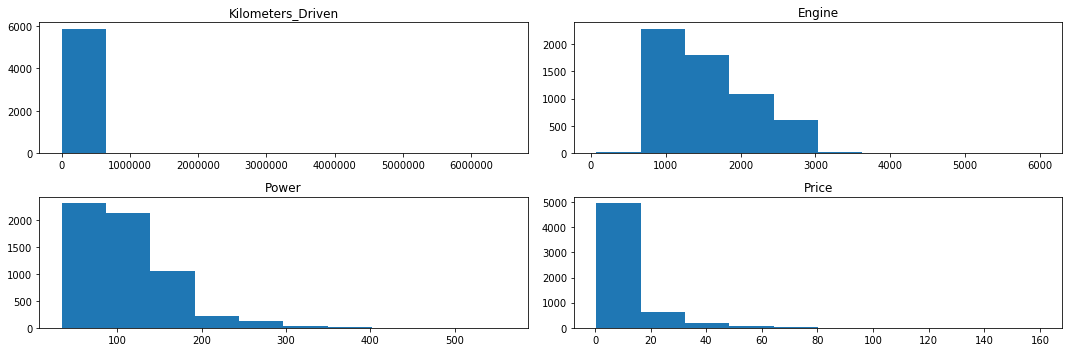

In [16]:
columns=['Kilometers_Driven','Engine','Power','Price']
plt.figure(figsize=(15,5))
for i,j in zip(columns, range(1,5)):
        plt.subplot(2,2,j)
        plt.hist(df[i])
        plt.title(i)
plt.tight_layout()
plt.show()

Dağılım grafiklerinde Kilometers_Driven da bir sorun var gibi tüm arabaların aynı miktarda yol almış olması makul değil. Aykırı bir değer dağılımı bu şekilde baskılıyor olabilir.Bunu aklımızda tutalım.Kutu grafikler aracılığıyla aykırı değer kontrolü yapalım.Dağılım grafikleri diğerlerinde de sağa çarpık, hepsinde bu sorunun olabileceğine işaret ediyor.

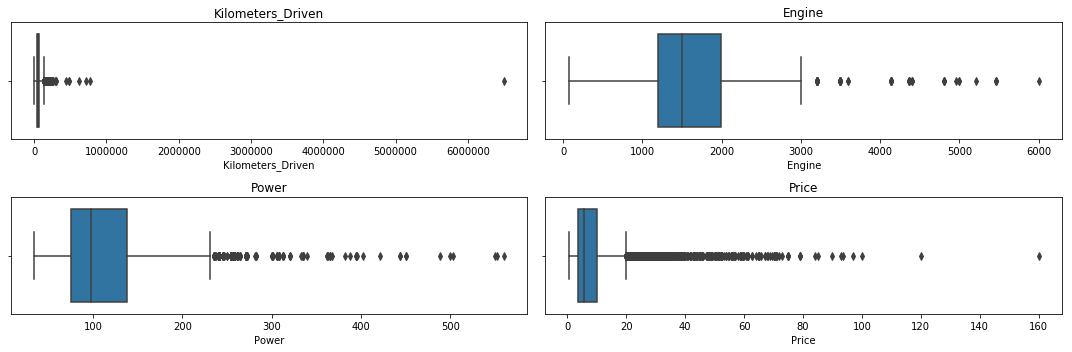

In [17]:
#kutu grafiklerle aykırı değer kontrolü yapıyoruz.
#columns=['Kilometers_Driven','Engine','Power','Price']
plt.figure(figsize=(15,5))
for i,j in zip(columns, range(1,5)):
        plt.subplot(2,2,j)
        sns.boxplot(df[i])
        plt.title(i)
plt.tight_layout()
plt.show()

Dediğimiz gibi tüm değişkenlerde aykırı değer sorunu var. Ama Kilometers_Driven için tek bir aykırı değer diğerlerini
baskılamış bunun ne olduğuna bakalım. Aykırı değerlerle baş edebilmek adına ilerleyen kısımlarda değişkenlerimizin
log dönüşümlü hallerini kullanacağız.

In [18]:
df.sort_values(by='Kilometers_Driven',ascending=False).head(10)
#box plotda bir tane bariz aykırı değer vardı onun kontrolü.
#aslında bir sıfır fazla yazılmış.Düzeltiledebilir silinedebilir.

,Name,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Brand
2328,BMW X5 xDrive 30d M Sport,2017,6500000,Diesel,Automatic,First,2993.000,258.000,5.000,65.000,BMW
340,Skoda Octavia Ambition Plus 2.0 TDI AT,2013,775000,Diesel,Automatic,First,1968.000,141.000,5.000,7.500,Skoda
1860,Volkswagen Vento Diesel Highline,2013,720000,Diesel,Manual,First,1598.000,103.600,5.000,5.900,Volkswagen
358,Hyundai i10 Magna 1.2,2009,620000,Petrol,Manual,First,1197.000,78.900,5.000,2.700,Hyundai
3092,Honda City i VTEC SV,2015,480000,Petrol,Manual,First,1497.000,117.300,5.000,5.000,Honda
2823,Volkswagen Jetta 2013-2015 2.0L TDI Highline AT,2015,480000,Diesel,Automatic,First,1968.000,138.030,5.000,13.000,Volkswagen
4491,Hyundai i20 Magna Optional 1.2,2013,445000,Petrol,Manual,First,1197.000,82.900,5.000,4.450,Hyundai
3649,Tata Indigo LS,2008,300000,Diesel,Manual,First,1405.000,70.000,5.000,1.000,Tata
1528,Toyota Innova 2.5 G (Diesel) 8 Seater BS IV,2005,299322,Diesel,Manual,First,2494.000,102.000,8.000,4.000,Toyota
1975,Skoda Superb 1.8 TSI MT,2012,282000,Petrol,Manual,First,1798.000,160.000,5.000,3.300,Skoda


**Kilometers_Driven** değişkenin de bir satırın değeri girilirken bir sıfır fazla koydukları için değer aşırı yükselmiş bu da üstteki sorunlara neden olmuş. Bu değeri sileceğiz.

In [19]:
#df.sort_values(by='Engine').head(15)

In [20]:
#df.sort_values(by='Price',ascending=False).head(10)

In [21]:
df.Brand.value_counts() #sayısı çok az olanları çıkarmak bir tercih olabilir.
#6000 e yakın veri var 20 taneden az olanları sileceğim.aslında 100 den az olarak da denenenbilir. çünkü totalde %5 civarı eder.

Maruti           1175
Hyundai          1058
Honda             600
Toyota            395
Mercedes-Benz     316
Volkswagen        314
Ford              294
Mahindra          269
BMW               262
Audi              235
Tata              183
Skoda             172
Renault           145
Chevrolet         120
Nissan             89
Land               57
Jaguar             40
Mitsubishi         27
Mini               26
Fiat               23
Volvo              21
Porsche            16
Jeep               15
Datsun             13
Force               3
ISUZU               2
Bentley             1
Lamborghini         1
Isuzu               1
Ambassador          1
Name: Brand, dtype: int64

In [22]:
df.Owner_Type.value_counts()

First             4841
Second             925
Third              101
Fourth & Above       7
Name: Owner_Type, dtype: int64

In [23]:
df.Seats.value_counts()

5.000     4921
7.000      672
8.000      133
4.000       99
6.000       29
2.000       13
10.000       4
9.000        3
Name: Seats, dtype: int64

Üstte  yaptığımız bazı incelemelerde tespit ettiğimiz; veri kümesinde çok az yüzdesi olan ya da aykırı
değer olmaya aday bazı verileri silerek devam ediyoruz. Sİlincek verileri filtreleyip indeks değerlerini alıp ,siliyoruz.

In [24]:
#Burası silinecekler kosesi loc ile indexleri alıp sonra siliyorum.
#6000 e yakın veri olunca 5-10 tane bulunan değerlerin bir açıdan istisna olduğunu ve bunlardan bazılarının aykırı değerler de olduğunu
#görünce silip temizlemenin daha doğru bir analiz yapamaya yol açacağını düşündüm.
seats_index=df.loc[(df["Seats"]==2.00)|(df["Seats"]==10.00) |(df["Seats"]==9.00)].index
df.drop(seats_index,inplace=True)
model_index=df.loc[(df['Brand']=="Porsche")|(df['Brand']=="Jeep")|(df['Brand']=="Datsun")|(df['Brand']=="Force")|(df['Brand']=="ISUZU")|(df['Brand']=="Ambassador")|(df['Brand']=="Bentley")|(df['Brand']=="Isuzu")|(df['Brand']=="Lamborghini")].index
df.drop(model_index,inplace=True)
price_index=df.loc[df["Price"] >=80.000].index
df.drop(price_index,inplace=True)
owner_index=df.loc[df["Owner_Type"] =='Fourth & Above'].index
df.drop(owner_index,inplace=True)
max_km_index=df.loc[df["Kilometers_Driven"]==df["Kilometers_Driven"].max()].index
df.drop(max_km_index,inplace=True)
km_index=df.loc[df["Kilometers_Driven"]<1000].index
df.drop(km_index,inplace=True)

Silinen değerlerden sonra veri kümemizin son durumuna bakalım.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5788 entries, 0 to 6018
Data columns (total 11 columns):
Name                 5788 non-null object
Year                 5788 non-null int64
Kilometers_Driven    5788 non-null int64
Fuel_Type            5788 non-null object
Transmission         5788 non-null object
Owner_Type           5788 non-null object
Engine               5788 non-null float64
Power                5788 non-null float64
Seats                5788 non-null float64
Price                5788 non-null float64
Brand                5788 non-null object
dtypes: float64(4), int64(2), object(5)
memory usage: 542.6+ KB


Şimdi de çubuk garfikler aracılığıyla kategorik değişkenlerimiz ve hedef değişkenimiz arasındaki ilişkiye bakalım.

In [26]:
#kategoriklerle hedef arasındaki ilişkiye bakalım grafiklerle.

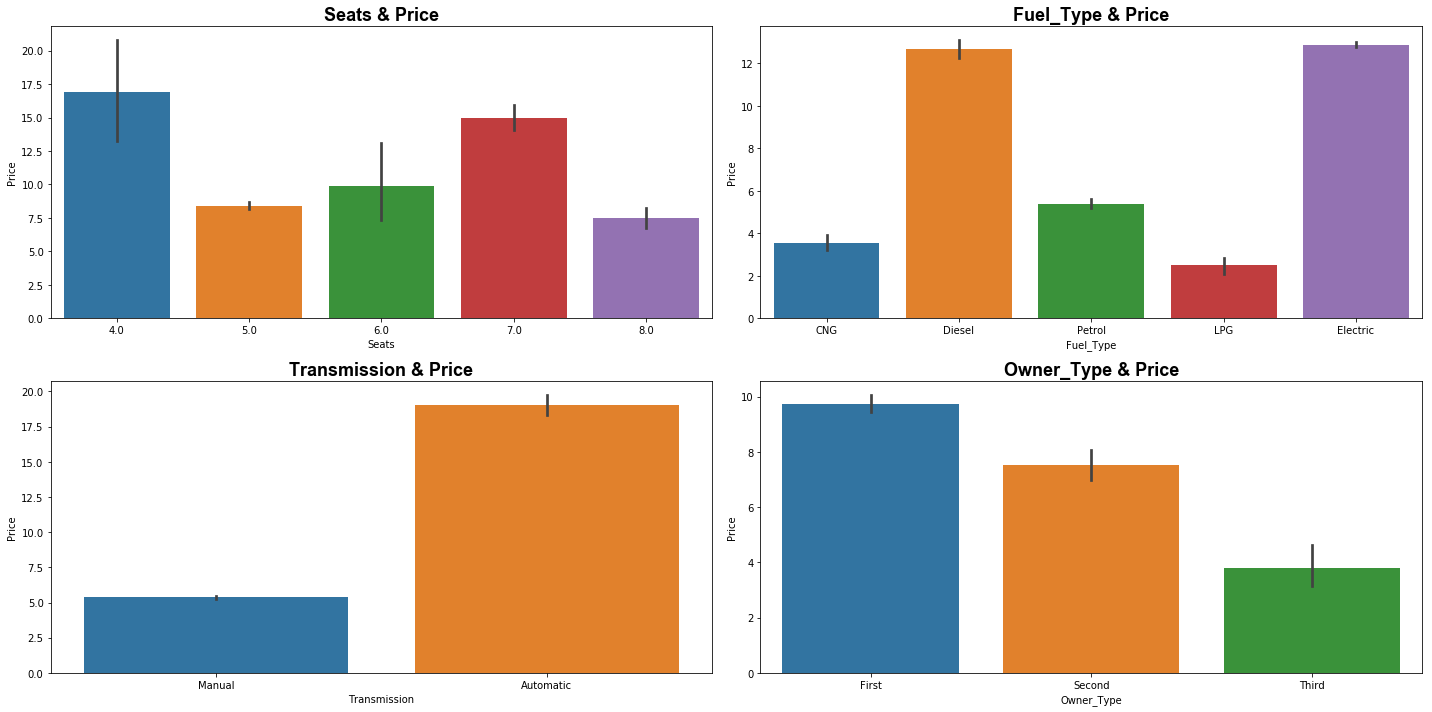

In [27]:
columns=['Seats','Fuel_Type','Transmission','Owner_Type']
title_font = {'family': 'arial', 'color': 'black','weight': 'bold','size': 18 }

plt.figure(figsize=(20,10))
for i,j in zip(columns, range(1,5)):
        plt.subplot(2,2,j)
        sns.barplot(df[i],df['Price'])
        plt.title(i+' '+'&'+' ''Price',fontdict = title_font)
plt.tight_layout()
plt.show()


Grafiklerin hepsinde değerler farklılaştıkça az ya da çok bağımlı değişkenin değerinde de bir değişme görülüyor. Tabii ki bu değişimlerin istatistiksel olarak anlamlı olup olmadıklarını testler aracılığıyla kontrol etmeliyiz. İlerleyen aşamada model seçimine tüm değişkenleri katarak başlayıp,katsayısı anlamsız olanları çıkararak devam edeceğimiz için testleri yapmadan sonraki kısma geçerek yorumlamayı oraya bırakıyoruz. 

Veri analizimize sürekli değişkenlerimizin log dönüşümlerini yapıp ilk halleriyle karşılaştırarark devam ediyoruz.

In [28]:
#seats hariç sürekli değişkenlerin logunu alıp yeni kolonlara atadım.
df['log_Price']=np.log(df["Price"])
df['log_Kilometers_Driven']=np.log(df["Kilometers_Driven"])
df['log_Engine']=np.log(df["Engine"])
df['log_Power']=np.log(df["Power"])

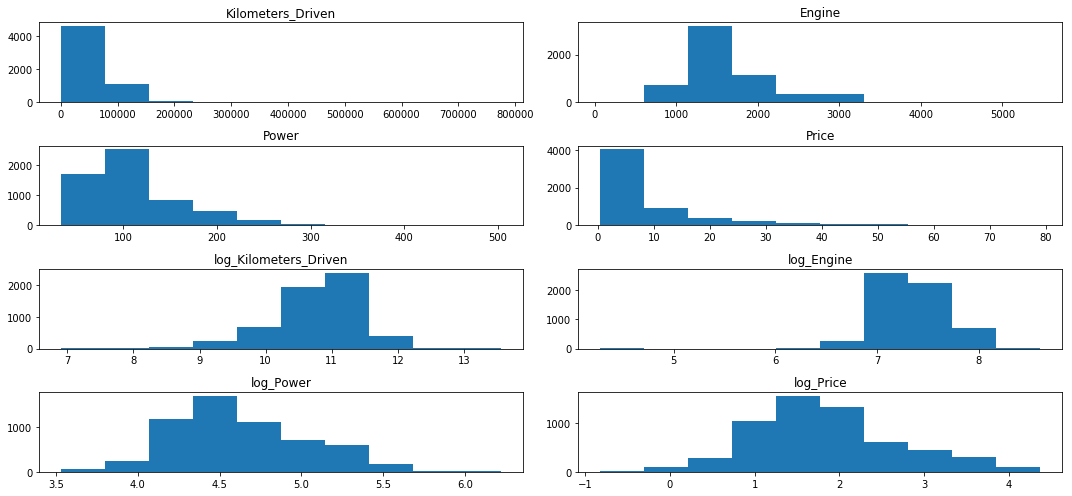

In [29]:
#log dönüşümleri yaptıktan sonra dağılımlarına bakalım.
columns=['Kilometers_Driven','Engine','Power','Price','log_Kilometers_Driven','log_Engine','log_Power','log_Price']
plt.figure(figsize=(15,7))
for i,j in zip(columns, range(1,9)):
        plt.subplot(4,2,j)
        plt.hist(df[i])
        plt.title(i)
plt.tight_layout()
plt.show()

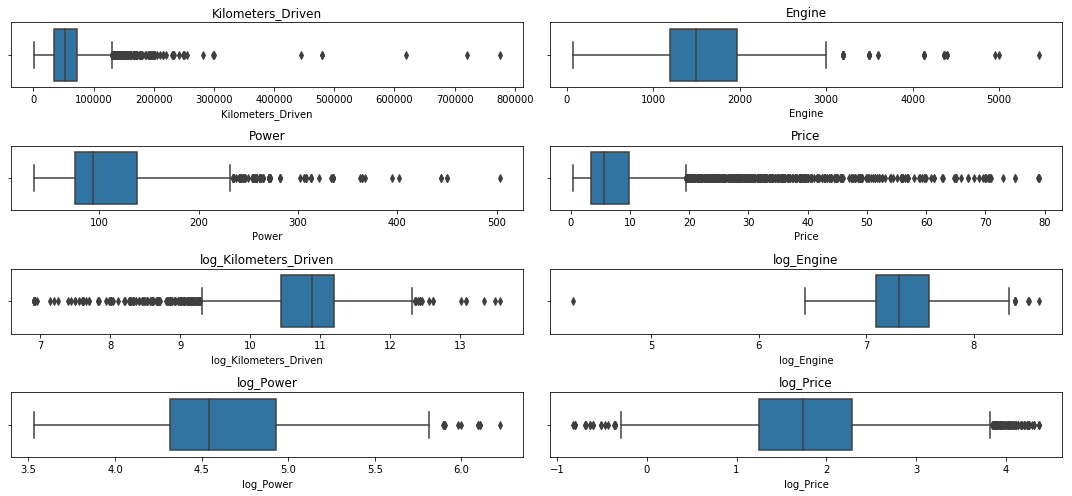

In [30]:
#hem bazı verileri sildim icinde aykırı olanlar da vardı.hem de log dönüşümü yaptık kıyaslı son hallerine bakalım.
#columns=['Kilometers_Driven','Engine','Power','Price','log_Kilometers_Driven','log_Engine','log_Power','log_Price']
plt.figure(figsize=(15,7))
for i,j in zip(columns, range(1,9)):
        plt.subplot(4,2,j)
        sns.boxplot(df[i])
        plt.title(i)
plt.tight_layout()
plt.show()

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,5788.000,2013.464,3.147,1998.000,2012.000,2014.000,2016.000,2019.000
Kilometers_Driven,5788.000,57450.418,37631.778,1000.000,34000.000,53000.000,72506.000,775000.000
Engine,5788.000,1612.853,579.367,72.000,1198.000,1493.000,1968.000,5461.000
Power,5788.000,111.922,50.672,34.200,75.000,94.000,138.030,503.000
Seats,5788.000,5.287,0.776,4.000,5.000,5.000,5.000,8.000
Price,5788.000,9.293,10.270,0.440,3.507,5.700,9.900,79.000
log_Price,5788.000,1.833,0.849,-0.821,1.255,1.740,2.293,4.369
log_Kilometers_Driven,5788.000,10.758,0.703,6.908,10.434,10.878,11.191,13.561
log_Engine,5788.000,7.328,0.335,4.277,7.088,7.309,7.585,8.605
log_Power,5788.000,4.631,0.407,3.532,4.317,4.543,4.927,6.221


Grafiklerde logaritmik dönüşümün dağılımları belli oranda düzelttiğini söyleyebilriz.
Özellikle de Power ve Price değişkeni için hayli işe yaramış görünüyor. Ama hala aykırı değerlerimiz var.
Temel istatistiklere bakınca değişkenlerin logaritmik hallerinin verilerinin daha iyi olduğunu söyleyebiliriz. Şimdi de korelasyon matrisine bakalım.

In [32]:
df.corr()

,Year,Kilometers_Driven,Engine,Power,Seats,Price,log_Price,log_Kilometers_Driven,log_Engine,log_Power
Year,1.000,-0.443,-0.068,0.012,0.022,0.317,0.494,-0.500,-0.061,0.035
Kilometers_Driven,-0.443,1.000,0.178,0.022,0.203,-0.158,-0.175,0.817,0.189,0.042
Engine,-0.068,0.178,1.000,0.860,0.471,0.651,0.683,0.178,0.974,0.853
Power,0.012,0.022,0.860,1.000,0.176,0.768,0.770,0.040,0.843,0.964
Seats,0.022,0.203,0.471,0.176,1.000,0.133,0.216,0.180,0.450,0.218
Price,0.317,-0.158,0.651,0.768,0.133,1.000,0.869,-0.174,0.621,0.714
log_Price,0.494,-0.175,0.683,0.770,0.216,0.869,1.000,-0.190,0.690,0.784
log_Kilometers_Driven,-0.500,0.817,0.178,0.040,0.180,-0.174,-0.190,1.000,0.195,0.061
log_Engine,-0.061,0.189,0.974,0.843,0.450,0.621,0.690,0.195,1.000,0.883
log_Power,0.035,0.042,0.853,0.964,0.218,0.714,0.784,0.061,0.883,1.000


Sürekli değişkenlerimiz farklı birimlerden ve değişken aralıklardan geldikleri için logaritmaları alınmış hallerini kullanmalıyız.   
Bağımlı değişkenin logaritmik halinin, diğer değişkenlerin normal halleri ile olan korelasyonu, kendi normal halinin korelasyonundan fazla.  
Aynı şekilde diğer değişkenlerin logaritmik halleri de bağımlı değişkenin logaritmik hali ile kendi normal hallerinden daha fazla koreleler.
Korelasyon tablosundaki değişkenlerin bağımlı değişken ile korelasyon miktarlarına göre sıralarsak:  
**log_power** > **log_Engine** > **Year** > **Seats** > **log_Kilometers_Driven**  
Son olarak da bağımsız değişken adaylarının kendi içlerindeki korelasyon miktarlarına bakalım.  
**Power**-**Engine** ikilisinin çok fazla korele olduğu görülüyor.
Modellerimiz için değişken seçiminde bu bilgileri göz önünde bulundurmalıyız. 

### 3.Model Oluşturma ve Seçme

Model oluştururken ilk olarak çoklu doğrusallık olmaması için birbiri ile korelasyonu yüksek olan
Engine-Power ikilisinden bağımlı değişken ile daha yüksek korelasyonu olan power değişkenini seçerek başlıyoruz.
Sonrasında Name ve Brand değişkeni hariç tüm değişkenleri modele ekliyoruz. Brand değişkeni dahil edildiğinde daha yüksek R2 elde ediyoruz ama diğer tüm değişkenleri baskıladığından ve level sayısı fazla olduğu için modeli karmaşık hale getirdiğinden dolayı o olmadan yolumuza devam ediyoruz. Sürekli değişkenlerimizden logaritmasını aldıklarımızı modele katıyoruz bağımlı değişkenimizin de logaritması alınmış halini regresyona katıyoruz.

Modeller arası geçişlerde hangi değişkenin çıkarılması gerektiğine de katsayısının **p-value** miktarını ve bağımlı değişken ile **korelasyon** miktarını gözönüne alarak karar vereceğiz.  
 **Ayarlanmıs R^2** ve **AIC** kriterlerine göre de önceki sonraki modelin kalitesini yorumlayacağız. 

Kategorik değişkenlerin dummy hallerinin base levellarını yazalım:  
* Fuel_Type -> CNG
* Transmission -> Automatic
* Owner_Type -> First

Model 1 tüm değişkenleri içeriyor.

In [33]:
#model1 tüm değişkenler var.  
X=df[['Year','log_Kilometers_Driven','Fuel_Type','Transmission','Owner_Type','log_Power','Seats']]
y=df['log_Price']

In [34]:
X = pd.get_dummies(data=X, drop_first=True) 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 66)

In [36]:

X_train=sm.add_constant(X_train)
result1=sm.OLS(y_train,X_train).fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     2831.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:14:55   Log-Likelihood:                -1045.5
No. Observations:                4630   AIC:                             2115.
Df Residuals:                    4618   BIC:                             2192.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -220.78

Model1 için Fuel_Type değişkeninin Diesel ve LPG kategorisinin katsayıları anlamsız çıktı ama bu değişkenin diğer kategoırileri anlamlı göründüğünden modelde tutmaya devam edeceğiz. Katsayıların istatistksel anlamlılık durumlarından değişken elemesi yapamadığımızdan yolumuza hedef ile korelasyonu en az olan **log_Kilometers_Driven**'ı çıkararak devam ediyoruz.

In [37]:
#model2
#'log_Kilometers_Driven', cıkarıldı.
X=df[['Year','Fuel_Type','Seats','Transmission','Owner_Type','log_Power']]
y=df['log_Price']

In [38]:
X = pd.get_dummies(data=X, drop_first=True)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 66)

In [40]:
X_train=sm.add_constant(X_train)
result2=sm.OLS(y_train,X_train).fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     3068.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:14:56   Log-Likelihood:                -1075.8
No. Observations:                4630   AIC:                             2174.
Df Residuals:                    4619   BIC:                             2244.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -236.0580    

Model2 için de yine Fuel_Type değişkeninin Diesel ve LPG kategorilerinin katsayıları anlamsız çıktı.Ayarlanmış R^2 miz Binde 2 düştü ve AIC miktarımız arttı. Hedef ile en az korele olan  **Seats** değişkenini çıkarıyoruz.

In [41]:
#model3
#'Seats' cıkarıldı.,
X=df[['Year','Transmission','Owner_Type','Fuel_Type','log_Power']]
y=df['log_Price']

In [42]:
X = pd.get_dummies(data=X, drop_first=True)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 66)

In [44]:
X_train=sm.add_constant(X_train)
result3=sm.OLS(y_train,X_train).fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     3355.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:14:57   Log-Likelihood:                -1108.8
No. Observations:                4630   AIC:                             2238.
Df Residuals:                    4620   BIC:                             2302.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -236.1521    

Model3 de Bu sefer 0.05 anlamlılık seviyesine göre Fuel_Type değişkeninin LPG kategorisi anlamsız çıktı. Ayarlanmış R^2 miz
önceki modele göre Binde 2 azaldı ve AIC miktarımız arttı. Geriye kalan sürekli değişkenlerimizin hedef ile korelasyon miktarları 0.5 seviyesine yakın veya üzerinde olduğundan şimdilik onları modelde tutuyoruz. Kategorik değişkenlerden sezgisel olarak daha az anlamlı olabilir diye düşündüğümüz **Owner_Type** değişkenini çıkararak devam ediyoruz.


In [45]:
#model4
#  'Owner_Type' gitti.
X=df[['Year','Transmission','Fuel_Type','log_Power']]
y=df['log_Price']

In [46]:
X = pd.get_dummies(data=X, drop_first=True)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 66)

In [48]:
X_train=sm.add_constant(X_train)
result4=sm.OLS(y_train,X_train).fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Price   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     4282.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:14:58   Log-Likelihood:                -1124.0
No. Observations:                4630   AIC:                             2264.
Df Residuals:                    4622   BIC:                             2316.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -242.5257    

Model4 de yine Fuel_Type değişkeninin LPG kategorisinin katsayısı anlamsız çıktı.
Bir önceki modele göre Ayarlanmış R^2 binde 1 azalırken AIC miktarı arttı. Bu sefer yine kategorik değişkenlerden bazı kategorileri anlamlı bazısı anlamsız çıkan **Fuel_Type** değişkenini çıkarıyoruz modelimizden.

In [49]:
#model5
# 'Fuel_Type' gitti

X=df[['Year','Transmission','log_Power']]
y=df['log_Price']

In [50]:
X = pd.get_dummies(data=X, drop_first=True)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 66)

In [52]:
X_train=sm.add_constant(X_train)
result5=sm.OLS(y_train,X_train).fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     8357.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:14:58   Log-Likelihood:                -1479.8
No. Observations:                4630   AIC:                             2968.
Df Residuals:                    4626   BIC:                             2993.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -251.7971    

Model5 için tüm değişkenlerin katsayıları anlamlı görünüyor. Önceki modele göre ayarlanmış R^2binde 22 azaldı ve AIC miktarı arttı. Model oluşturmayı burada bırakıp sonuçları yorumlamaya geçiyoruz.

### 4.Model Sonuçlarını Yorumlama

Modeller arasında geçişleri buraya kadar tek tek özellik çıkarınca aşırı oynama olmadan azalan adj-R2 ile bitirdik. Son modellerde **3 değişkenle %84** varyans açıklanabiliyor görünüyor. Az değişkenle kabul edilebilir bir R^2 oranı bizim için.Bu yüzden;


**Model5**'i son modelimiz olarak seçiyoruz.Modelden elde ettiğimiz katsayılardan sonra denklemimiz şu şekilde: 
  
  
**log_Price= -251.7971 + 0.1228* Year +1.4014* log_Power-0.2877* Transmission_Manual**

**Year** bağımsız değişkeninde bir birim artış **Price** değişkeninde **%12**lik bir artısa neden oluyor.  
**Power** değişkenindeki **%1**lik bir artış **Price** değişkeninde **%1.4** lük bir artışa neden oluyor.  
**Transmission** değişkeninin değerinin **Manual** olması **Price** değişkeninin değerini **%28** azaltıyor.  
Aynı şekilde **Transmission** değişkeninin değer **Automatic** olduğunda **Price** değişkeninin değeri **%28** artıyor.

### 5.Tahmin Yapma

In [53]:
#model5 için tahmin ve mse değerleri
X_test=sm.add_constant(X_test)
result5_predicted=result5.predict(X_test) #esas tahminler 
train5_predicted=result5.predict(X_train)
mse1=mse(y_test,result5_predicted)
#print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test,result1_predicted)))

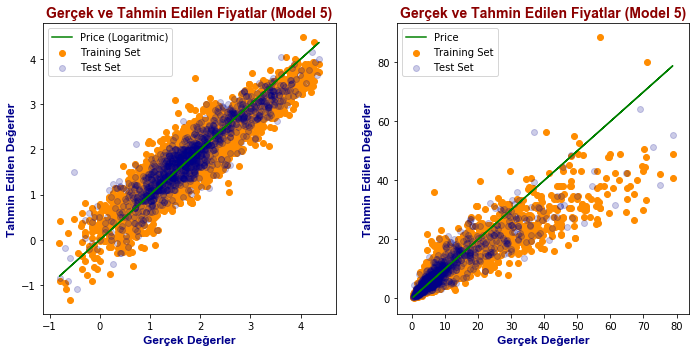

In [54]:
header_font = {'family':'arial', 'color':'darkred', 'weight':'bold', 'size':14}
axis_font = {'family':'arial', 'color':'darkblue', 'weight':'bold', 'size':12}

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_train, train5_predicted, color="darkorange", label="Training Set")
plt.scatter(y_test, result5_predicted, color="darkblue", label="Test Set", alpha=0.2)
plt.plot(y_test, y_test, color="green", label="Price (Logaritmic)")
plt.xlabel("Gerçek Değerler", fontdict=axis_font)
plt.ylabel("Tahmin Edilen Değerler", fontdict=axis_font)
plt.title("Gerçek ve Tahmin Edilen Fiyatlar (Model 5)", fontdict=header_font)
plt.legend(loc = "upper left")
plt.subplot(1,2,2)
plt.scatter(np.exp(y_train), np.exp(train5_predicted), color="darkorange", label="Training Set")
plt.scatter(np.exp(y_test), np.exp(result5_predicted), color="darkblue", label="Test Set", alpha=0.2)
plt.plot(np.exp(y_test), np.exp(y_test), color="green", label="Price")
plt.xlabel("Gerçek Değerler", fontdict=axis_font)
plt.ylabel("Tahmin Edilen Değerler", fontdict=axis_font)
plt.title("Gerçek ve Tahmin Edilen Fiyatlar (Model 5)", fontdict=header_font)
plt.legend(loc = "upper left")


plt.tight_layout()
plt.show()

**Price** değişkeninin hem normal hem de logaritmic halinin,
tahmin edilen ve gerçekte olan değerlerin eğitim ve test kümeleri için çizilmiş garfiklerini görüyoruz yukarda.
Modelin fiyatlar yükseldikçe tahmin başarısının azaldığı görülüyor.

Seçtiğimiz modelimizin overfit sorunu olup olmadığını anlamak için çapraz doğrulama yapıyoruz.

In [55]:
#modelin sci-kit learn ile tekrar inşaası
X=df[['Year','Transmission','log_Power']]
y=df['log_Price']
X = pd.get_dummies(data=X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 66)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
test_dogruluk= model_selection.cross_val_score(lin_reg, X_test, y_test, cv = 10).mean()
print("Test Doğruluk Ortalaması:", test_dogruluk)

egitim_dogruluk= model_selection.cross_val_score(lin_reg, X_train, y_train, cv = 10).mean()
print("Eğitim Doğruluk Ortalaması:", egitim_dogruluk)


Test Doğruluk Ortalaması: 0.8507028394245916
Eğitim Doğruluk Ortalaması: 0.8426211650662555


Test ve eğitim kümelerinin dogruluk ortalamaları birbirine yakın olduğundan modelimiz durağan ve aşırı uyum sorunu yok diyebiliriz.

### 6.Varsayımların Sağlanması Kontrolü

Lİneer Regresyon Analizinde OLS fonksiyonu için bazı varsayımlar vardır. Modelimizin doğruluğundan, tahminlerimizin keskinliğinden emin olabilmek için bu varsayımların sağlanması gerekmektedir. Sağlanmadıkları durumlar için sebepleri araştırılıp giderilmeye çalışılmalıdır.Varsayımlar şunlardır:  
1:Katsayılarla modelin ilişkisi doğrusal olmalıdır.  
2:Hata teriminin ortalaması sıfır olmalıdır.  
3:Homoscedasticity sağlanmalıdır.   
4:Düşük çoklu doğrusallık/low multicollinearity olmalıdır.  
5:Hata terimleri birbiriyle ilişkisiz olmalıdır.  
6:Bağımsız değişkenler hatalarla korele olmamalıdır.(Exogeneity)  
7:Hatalar normal dağılımlı olmalıdır.  


**1:** Katsayılarla modelin ilişkisi doğrusal olmalıdır.  
Modelimizin denklemine baktığımızda  **log_Price= -251.7971 + 0.1228* Year +1.4014* log_Power-0.2877* Transmission_Manual**  varsayımın sağlandığı görülüyor.

**2:** Hata teriminin ortalaması sıfır olmalıdır.  
Aşağıda hesapladığımızda 0'a çok yakın bir değer çıktığı görülüyor.

In [57]:
residuals=y_test-result5_predicted
print("Hata teriminin ortalaması={:.10f}".format(residuals.mean()))

Hata teriminin ortalaması=-0.0076607528


**3:** Homoscedasticity sağlanmalıdır.  
Bu varsayım hatanın eşvaryanslı olması gerektiğini söyler.Grafiklerle ön bakış yapıp testler ile kontrol edelim.

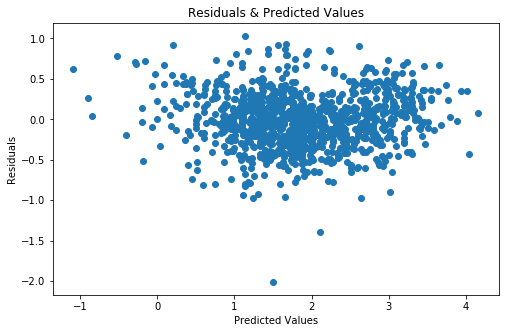

In [58]:
plt.figure(figsize=(8,5))
plt.scatter(result5_predicted,residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title("Residuals & Predicted Values")
plt.show()

Hata ve tahmin edilen değerler grafiğine baktığımızda çok aşırı olmasa da U'ya benzer bir ilişki görülebilir.Bu bize Heteroskedasticity olduğunu düşündürüyor. Testler aracılığıyla bilgimizi kesinleştirelim. Yapabileceğimiz testlerden biri Levene Testi. Bu testin Null Hipotezi Eşvaryans olduğu şeklinde.

In [59]:
lev_test=levene(result5_predicted, residuals)
print("Levene test değeri   : {0:3g} ve p değeri : {1:.21f}".format(lev_test[0], lev_test[1]))

Levene test değeri   : 542.199 ve p değeri : 0.000000000000000000000


Testin sonucuna göre null hipotezi reddediyoruz yani hatalarımız eşvaryanslı değil. Heteroskedastisity sorunumuz var.
Bunun sebepleri aşağıdakiler olabilir:  
* Hedef ile ilgili bilgi içeren önemli bir değişkeni modele katmamış olabiliriz.
* Veri setimizin range'i yani aralığı çok fazla olabilir. Bizim durumumuzda veri setimiz bu şarta uyuyor. Bundan kaynaklanıyor olabilir.
* Veri toplama aşamasındaki yanlışlıklar.Bu konuda bilgimiz yok 
* Aykırı değerler. Bu da durumumuza uyuyor dönüşüm uygulasak bile hala aykırı sayılabilcek değerlerimiz var.  
Bu duruma rağmen tahmin katsayılarımız hala geçerlidir. Bunu unutmayalım.

**4:** Düşük çoklu doğrusallık/low multicollinearity olmalıdır.  
Model kurmaya başlarken bu şartı sağlamak için birbiriyle korelasyonu yüksek olan değişkenleri dahil etmedik. Seçtiğimiz modelin bağımsız değişkenleri içinde birbiriyle yüksek korelasyonu olan bulunmuyor.

**5:** Hata terimleri birbiriyle ilişkisiz olmalıdır.  
Hataların grafiğini çizdirerek ya da autocorrelation fonksiyonunu kullanarak bunu anlayabiliriz.

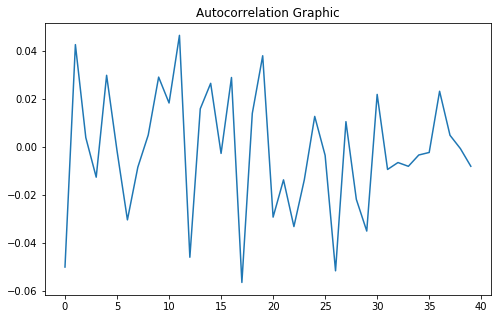

In [60]:
acf_data = acf(residuals)
plt.figure(figsize=(8,5))
plt.plot(acf_data[1:])
plt.title("Autocorrelation Graphic")
plt.show()


Modelimizin hataları arasındaki otokorelasyon gerçekten çok düşüktür (-0,06 ile 0,05 arasında).

**6:** Bağımsız değişkenler hatalarla korele olmamalıdır.(Exogeneity)  
Bu şart sağlanmadığında tahminlerimiz yanlı olacağından keskin sonuçlar için bu şartı sağlamalıyız. Bunu anlamanın bir yolu da modelimizin çıktısındaki **Durbin-Watson** Değerine bakmakır. Bu değer **2.0** civarlarında ise sorunumuz yok demektir. Ama +1/-1 durumunda sorun olduğunu düşünmeliyiz. Bizim modelimiz için bu değer **2.017** olduğundan varsayım sağlanıyor diyebiliriz.

**7:** Hatalar normal dağılımlı olmalıdır.  


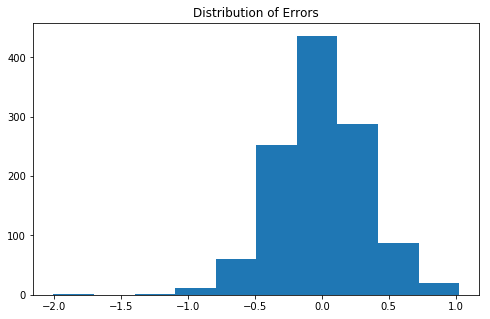

In [61]:
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=10)
plt.title("Distribution of Errors")
plt.show()

In [62]:
jb_test = jarque_bera(residuals)
print("Jarque-Bera test değeri : {0} ve p değeri : {1}".format(jb_test[0], jb_test[1]))

Jarque-Bera test değeri : 94.73653259746003 ve p değeri : 0.0


Üstteki testin null hipotezi hataların normal dağıldığı şeklinde. Sonuca göre hatalarımız normal dağılmıyor demektir.Modelimiz varsayımlardan **3  numaralı ve  7 numaralı** olanları sağlamıyor.

### 7.Sonuç

Kullanılmış araba veri kümemizi kullanarak fiyat tahmini yapmamızı sağlayacak uygun modeli bulmaya çalıştık. Oluşturduğumuz alternatif modeller içinde en az değişkenle kendi açımızdan kabul edilebilir bir varyansı açıklayan 5. modeli seçtik. Modelimiz kabul edilebilir miktarda başarılı olsa da bazı açılardan hala iyileştirilmesi gerekiyor. İlerleyen zamanlarda modelin geliştirilmesi ya da daha iyi bir modelin bulunması için eklemeler yapılabilir.